# Explore UK Crime Data with Pandas and GeoPandas


## Table of Contents

1. [London boroughs](#boroughs)<br>
2. [Crime data](#crime)<br>
    2.1. [Load data](#load2)<br>
    2.2. [Explore data](#explore2)<br>

In [14]:
import pandas as pd
import geopandas as gpd
#import numpy as np
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

<div class="alert alert-danger" style="font-size:100%">
When you are using <b>Watson Studio</b> to run the workshop you will need to add the project token to your notebook that you created earlier to be able to access the shape files. 

* Click the 3 dots at the top of the notebook to insert the project token. This will create a new cell in the notebook that you will need to run first before continuing with the rest of the notebook. If you are sharing this notebook you should remove this cell, else anyone can use you Cloud Object Storage from this project.

If you cannot find the new cell it is probably at the top of this notebook. Scroll up, run the cell and continue with the rest of the notebook.

* Also add the following files to your Cloud Object Store (click the 1010 button at the top right if you do not see the menu on the right of the notebook):
    - 2018-1-metropolitan-street.zip
    - 2018-2-metropolitan-street.zip
    - 2018-metropolitan-stop-and-search.zip
* And run the following cell with the helper function

</div> 

In [2]:
# define the helper function 
def download_file_to_local(project_filename, local_file_destination=None, project=None):
    """
    Uses project-lib to get a bytearray and then downloads this file to local.
    Requires a valid `project` object.
    
    Args:
        project_filename str: the filename to be passed to get_file
        local_file_destination: the filename for the local file if different
        
    Returns:
        0 if everything worked
    """
    
    project = project
    
    # get the file
    print("Attempting to get file {}".format(project_filename))
    _bytes = project.get_file(project_filename).read()
    
    # check for new file name, download the file
    print("Downloading...")
    if local_file_destination==None: local_file_destination = project_filename
    
    with open(local_file_destination, 'wb') as f: 
        f.write(bytearray(_bytes))
        print("Completed writing to {}".format(local_file_destination))
        
    return 0

<a id="boroughs"></a>
## 1. London boroughs

In [3]:
# load data from a url
boroughs = gpd.read_file("https://skgrange.github.io/www/data/london_boroughs.json")

In [4]:
boroughs.head()

,id,name,code,area_hectares,inner_statistical,geometry
0,1,Kingston upon Thames,E09000021,3726.117,0,(POLYGON ((-0.330679062942453 51.3290110106029...
1,2,Croydon,E09000008,8649.441,0,(POLYGON ((-0.064021239620113 51.3186376598749...
2,3,Bromley,E09000006,15013.487,0,"(POLYGON ((0.012130938509177 51.2995990596564,..."
3,4,Hounslow,E09000018,5658.541,0,"(POLYGON ((-0.244562394525054 51.48870217634, ..."
4,5,Ealing,E09000009,5554.428,0,(POLYGON ((-0.411832689731467 51.5340838625761...


<a id="crime"></a>
## 2. Crime data

The crime data is pre-processed in this [notebook](https://github.com/IBMDeveloperUK/foss4g-geopandas/blob/master/notebooks/prepare-uk-crime-data.ipynb) so it is easier to read here. We will only look at data from 2018. But feel free to also load the data from 2017 that is also provided in repository. Or adapt the pre-processing notebook to explore even more data.

Data is downloaded from https://data.police.uk/ ([License](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/))

<a id="load2"></a>
### 2.1. Load data

This dataset cannot be loaded into a geoDataFrame directly. Instead the data is loaded into a DataFrame and then converted:

In [40]:
street = pd.read_csv("../data/2018-1-metropolitan-street.zip")
street2 = pd.read_csv("../data/2018-2-metropolitan-street.zip")
street = street.append(street2) 

stop_search = pd.read_csv("../data/2018-metropolitan-stop-and-search.zip")

<div class="alert alert-danger" style="font-size:100%">
When you are using <b>Watson Studio</b> to run the workshop you will get an error with the above cell. Uncomment the below cell and run this instead to load the data from COS.
</div> 

In [41]:
#download_file_to_local('2018-1-metropolitan-street.zip', project=project)
#download_file_to_local('2018-2-metropolitan-street.zip', project=project)
#street = pd.read_csv("./2018-1-metropolitan-street.zip")
#street2 = pd.read_csv("./2018-2-metropolitan-street.zip")
#street = street.append(street2) 

#download_file_to_local('2018-metropolitan-stop-and-search.zip', project=project)
#stop_search = pd.read_csv("./2018-metropolitan-stop-and-search.zip")

In [42]:
street.head()

,Unnamed: 0,Crime ID,Month,Longitude,Latitude,Location,LSOA code,Crime type,Last outcome category,Context
0,0,NaN,2018-01,0.136387,51.589215,On or near Billet Road,E01000027,Anti-social behaviour,NaN,NaN
1,1,NaN,2018-01,0.140634,51.583427,On or near Rams Grove,E01000027,Anti-social behaviour,NaN,NaN
2,2,NaN,2018-01,0.140192,51.582311,On or near Hatch Grove,E01000027,Anti-social behaviour,NaN,NaN
3,3,NaN,2018-01,0.137065,51.583672,On or near Police Station,E01000027,Anti-social behaviour,NaN,NaN
4,4,NaN,2018-01,0.137065,51.583672,On or near Police Station,E01000027,Anti-social behaviour,NaN,NaN


In [43]:
stop_search.head()

,Unnamed: 0,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Legislation,Object of search,Outcome,Outcome linked to object of search
0,0,Person search,2018-01-01T00:05:00+00:00,False,NaN,51.425491,-0.220473,Male,18-24,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Khat or Cannabis warning,NaN
1,1,Person search,2018-01-01T00:15:00+00:00,False,NaN,51.459996,-0.116896,Male,over 34,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,NaN
2,2,Person and Vehicle search,2018-01-01T00:16:00+00:00,False,NaN,51.542049,-0.380529,Male,25-34,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN
3,3,Person and Vehicle search,2018-01-01T00:17:00+00:00,False,NaN,51.613286,-0.065711,Male,25-34,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,NaN
4,4,Person search,2018-01-01T00:20:00+00:00,False,NaN,51.461004,-0.115876,Male,over 34,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN


#### Convert to geoDataFrames

In [44]:
street['coordinates'] = list(zip(street.Longitude, street.Latitude))
street['coordinates'] = street['coordinates'].apply(Point)
street = gpd.GeoDataFrame(street, geometry='coordinates')
street.head()

,Unnamed: 0,Crime ID,Month,Longitude,Latitude,Location,LSOA code,Crime type,Last outcome category,Context,coordinates
0,0,NaN,2018-01,0.136387,51.589215,On or near Billet Road,E01000027,Anti-social behaviour,NaN,NaN,POINT (0.136387 51.589215)
1,1,NaN,2018-01,0.140634,51.583427,On or near Rams Grove,E01000027,Anti-social behaviour,NaN,NaN,POINT (0.140634 51.583427)
2,2,NaN,2018-01,0.140192,51.582311,On or near Hatch Grove,E01000027,Anti-social behaviour,NaN,NaN,POINT (0.140192 51.582311)
3,3,NaN,2018-01,0.137065,51.583672,On or near Police Station,E01000027,Anti-social behaviour,NaN,NaN,POINT (0.137065 51.583672)
4,4,NaN,2018-01,0.137065,51.583672,On or near Police Station,E01000027,Anti-social behaviour,NaN,NaN,POINT (0.137065 51.583672)


In [45]:
stop_search['coordinates'] = list(zip(stop_search.Longitude, stop_search.Latitude))
stop_search['coordinates'] = stop_search['coordinates'].apply(Point)
stop_search = gpd.GeoDataFrame(stop_search, geometry='coordinates')
stop_search.head()

,Unnamed: 0,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Legislation,Object of search,Outcome,Outcome linked to object of search,coordinates
0,0,Person search,2018-01-01T00:05:00+00:00,False,NaN,51.425491,-0.220473,Male,18-24,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Khat or Cannabis warning,NaN,POINT (-0.220473 51.425491)
1,1,Person search,2018-01-01T00:15:00+00:00,False,NaN,51.459996,-0.116896,Male,over 34,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,NaN,POINT (-0.116896 51.459996)
2,2,Person and Vehicle search,2018-01-01T00:16:00+00:00,False,NaN,51.542049,-0.380529,Male,25-34,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,POINT (-0.380529 51.542049)
3,3,Person and Vehicle search,2018-01-01T00:17:00+00:00,False,NaN,51.613286,-0.065711,Male,25-34,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,NaN,POINT (-0.06571100000000001 51.613286)
4,4,Person search,2018-01-01T00:20:00+00:00,False,NaN,51.461004,-0.115876,Male,over 34,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,POINT (-0.115876 51.461004)


<a id="explore2"></a>
### 5.2. Explore data


<div class="alert alert-success">
 <b>EXERCISES</b> <br/> 
 Explore the data with Pandas. There are no right or wrong answers, the questions below give you some suggestions at what to look at. <br/> 

Noticed anything odd about the latitudes and longitudes? Read here how the data is anonymised: https://data.police.uk/about/.
</div>  

<div class="alert alert-success">
 <b>QUESTION 1 - Explore the street DataFrame</b> <br/> 
  <ul>
  <li>How much data is there?</li>
  <li>Are there missing values? Should these rows be deleted?  </li>
  <li>Which columns of the datasets contain useful information? What kind of categories are there and are they all meaningful?</li>
  <li>Convert the Date to datetime with <font face="Courier">.apply(lambda x: datetime.strptime(x, "%Y-%m")</font> </li>     
  </ul> 
</div>  

In [46]:
# answer 1


In [47]:
# %load https://raw.githubusercontent.com/IBMDeveloperUK/foss4g-geopandas/master/answers/crime_answer1.py
# number of data points
print ('rows in street: '+str(len(street)))

# columns 
print ('Columns: '+str(street.columns))

# categories
print ('Crime type: '+str(street['Crime type'].unique()))
print ('Last outcome category: '+str(street['Last outcome category'].unique()))
print (street['Context'].unique())

# delete columns
street = street.drop(columns=['Unnamed: 0','Latitude', 'Longitude','Context'])

# convert Date to datetime
street['Month'] = street['Month'].apply(lambda x: datetime.strptime(x, "%Y-%m"))

street.head()


rows in street: 1054600
Columns: Index(['Unnamed: 0', 'Crime ID', 'Month', 'Longitude', 'Latitude', 'Location',
       'LSOA code', 'Crime type', 'Last outcome category', 'Context',
       'coordinates'],
      dtype='object')
Crime type: ['Anti-social behaviour' 'Burglary' 'Criminal damage and arson'
 'Other theft' 'Vehicle crime' 'Violence and sexual offences'
 'Other crime' 'Drugs' 'Robbery' 'Shoplifting' 'Public order'
 'Bicycle theft' 'Theft from the person' 'Possession of weapons']
Last outcome category: [nan 'Offender given community sentence'
 'Investigation complete; no suspect identified'
 'Status update unavailable' 'Offender given a caution'
 'Court result unavailable' 'Defendant found not guilty'
 'Offender given a drugs possession warning' 'Offender sent to prison'
 'Offender given suspended prison sentence'
 'Offender given penalty notice' 'Local resolution'
 'Offender deprived of property' 'Offender fined'
 'Court case unable to proceed' 'Offender otherwise dealt with'


,Crime ID,Month,Location,LSOA code,Crime type,Last outcome category,coordinates
0,NaN,2018-01-01,On or near Billet Road,E01000027,Anti-social behaviour,NaN,POINT (0.136387 51.589215)
1,NaN,2018-01-01,On or near Rams Grove,E01000027,Anti-social behaviour,NaN,POINT (0.140634 51.583427)
2,NaN,2018-01-01,On or near Hatch Grove,E01000027,Anti-social behaviour,NaN,POINT (0.140192 51.582311)
3,NaN,2018-01-01,On or near Police Station,E01000027,Anti-social behaviour,NaN,POINT (0.137065 51.583672)
4,NaN,2018-01-01,On or near Police Station,E01000027,Anti-social behaviour,NaN,POINT (0.137065 51.583672)


<div class="alert alert-success">
 <b>QUESTION 2</b> - Which crime type occurs most often? And near which location? <br/> 
</div> 

> Hints: use [groupby()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) to summarize the data and [sort_values()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html) to sort the data. 

In [48]:
# answer 2


In [49]:
# %load https://raw.githubusercontent.com/IBMDeveloperUK/foss4g-geopandas/master/answers/crime_answer2.py
bystreet = street.groupby(['Location','Crime type']).count()
bystreet = bystreet.drop(columns=['Month', 'Last outcome category','coordinates','LSOA code'])
bystreet = bystreet.rename(index=str, columns={"Crime ID": "Number of crimes"})

bystreet.sort_values(by=['Number of crimes'], ascending=False).head()

Number of crimes
Location                  Crime type                                    
On or near Petrol Station Other theft                               9933
On or near Supermarket    Shoplifting                               8444
                          Violence and sexual offences              6689
On or near Shopping Area  Shoplifting                               6637
On or near Supermarket    Other theft                               6262

<div class="alert alert-success">
 <b>QUESTION 3 - Visualise the street DataFrame: </b> <br/> 
  <ul>
  <li> The total number of crimes per crime type </li>
  <li>The total number of crimes per month </li>
  </ul> 
</div> 

In [50]:
# answer 3


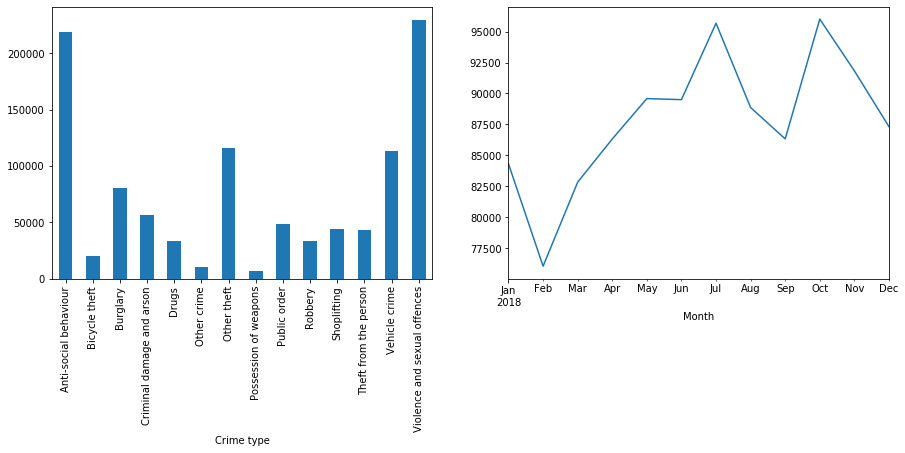

In [51]:
# %load https://raw.githubusercontent.com/IBMDeveloperUK/foss4g-geopandas/master/answers/crime_answer3.py
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

street['Crime type'].groupby(street['Crime type']).count().plot.bar(ax=ax1);

street['Crime type'].groupby(street['Month']).count().plot(ax=ax2);


<div class="alert alert-success">
 <b>QUESTION 4 - Explore the stop_search DataFrame</b> <br/> 
  <ul>
  <li>How much data is there?</li>
  <li>Are there missing values? Should these rows be deleted?  </li>
  <li>Which columns of the datasets contain useful information? What kind of categories are there and are they all meaningful?</li>
  <li>Convert the Date to datetime with <font face="Courier">.apply(lambda x: datetime.strptime(x, "%Y-%m")</font> </li>     
  </ul> 
</div> 

In [52]:
# answer 4


In [53]:
# %load https://raw.githubusercontent.com/IBMDeveloperUK/foss4g-geopandas/master/answers/crime_answer4.py
# number of data points
print ('rows in stop_search: '+str(len(stop_search)))

# columns 
print ('Columns: '+str(stop_search.columns))

# categories
print ('Policing operation: '+str(stop_search['Policing operation'].unique()))
print ('Legislation: '+str(stop_search['Legislation'].unique()))
print ('Object of search: '+str(stop_search['Object of search'].unique()))
print ('Outcome: '+str(stop_search['Outcome'].unique()))
print ('Outcome linked to object of search: '+str(stop_search['Outcome linked to object of search'].unique()))

# delete columns
stop_search = stop_search.drop(columns=['Unnamed: 0','Latitude', 'Longitude', 'Part of a policing operation', 'Policing operation', 'Outcome linked to object of search'])

# convert Date to datetime
stop_search['Date'] = stop_search['Date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S+00:00"))

stop_search.head()


rows in stop_search: 149284
Columns: Index(['Unnamed: 0', 'Type', 'Date', 'Part of a policing operation',
       'Policing operation', 'Latitude', 'Longitude', 'Gender', 'Age range',
       'Legislation', 'Object of search', 'Outcome',
       'Outcome linked to object of search', 'coordinates'],
      dtype='object')
Policing operation: [nan]
Legislation: ['Misuse of Drugs Act 1971 (section 23)'
 'Police and Criminal Evidence Act 1984 (section 1)'
 'Firearms Act 1968 (section 47)'
 'Criminal Justice and Public Order Act 1994 (section 60)']
Object of search: ['Controlled drugs' 'Offensive weapons' 'Stolen goods' nan
 'Evidence of offences under the Act' 'Fireworks'
 'Articles for use in criminal damage' 'Firearms'
 'Anything to threaten or harm anyone']
Outcome: ['Khat or Cannabis warning' 'Arrest' 'A no further action disposal'
 'Penalty Notice for Disorder' 'Community resolution'
 'Summons / charged by post' 'Caution (simple or conditional)']
Outcome linked to object of search: [nan]


,Type,Date,Gender,Age range,Legislation,Object of search,Outcome,coordinates
0,Person search,2018-01-01 00:05:00,Male,18-24,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Khat or Cannabis warning,POINT (-0.220473 51.425491)
1,Person search,2018-01-01 00:15:00,Male,over 34,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,POINT (-0.116896 51.459996)
2,Person and Vehicle search,2018-01-01 00:16:00,Male,25-34,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,POINT (-0.380529 51.542049)
3,Person and Vehicle search,2018-01-01 00:17:00,Male,25-34,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,POINT (-0.06571100000000001 51.613286)
4,Person search,2018-01-01 00:20:00,Male,over 34,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,POINT (-0.115876 51.461004)


<div class="alert alert-success">
 <b>QUESTION 5 - Visualise the stop_search DataFrame: </b> <br/> 
  <ul>
  <li> The total number of stops per object of search </li>
  <li> The total number of stops per outcome </li>
  <li> The total number of crimes per month (optional: split these out in categories)</li>
  </ul> 
</div>

In [ ]:
# answer 5

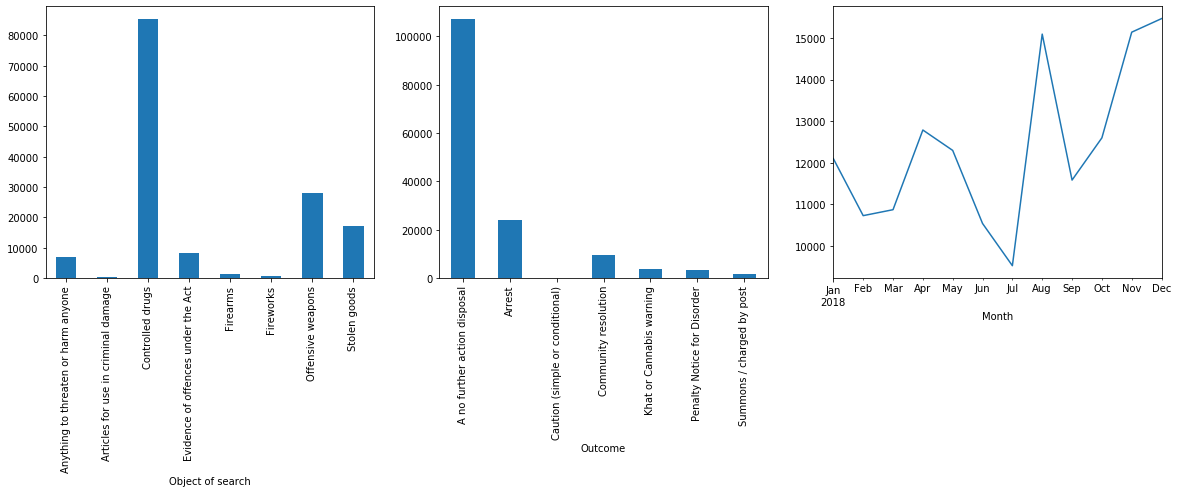

In [35]:
# %load https://raw.githubusercontent.com/IBMDeveloperUK/foss4g-geopandas/master/answers/crime_answer5.py
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

stop_search['Object of search'].groupby(stop_search['Object of search']).count().plot.bar(ax=ax1);

stop_search['Outcome'].groupby(stop_search['Outcome']).count().plot.bar(ax=ax2);

stop_search['Month'] = stop_search.Date.dt.to_period("M")
stop_search['Object of search'].groupby(stop_search['Month']).count().plot(ax=ax3);


### Some observations and ideas to further explore the data

* The number of stop and searches seems to go up. That is something you could investigate further. Is any of the categories increasing? 
* Another interesting question is how the object of search and the outcome are related. Are there types of searches where nothing is found more frequently? 
* How could you combine the two datasets?

### Spatial join

> The below solution was found [here](https://gis.stackexchange.com/questions/306674/geopandas-spatial-join-and-count) after googling for 'geopandas count points in polygon'

The `crs` needs to be the same for both GeoDataFrames. 

In [56]:
print(boroughs.crs)
print(stop_search.crs)

{'init': 'epsg:4326'}
None


Add a borough to each point with a spatial join. This will add the `geometry` and other columns from `boroughs2` to the points in `stop_search`. 

In [57]:
stop_search.crs = boroughs.crs
dfsjoin = gpd.sjoin(boroughs,stop_search) 
dfsjoin.head()

/Users/margriet/anaconda3/envs/foss4g/lib/python3.7/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


,id,name,code,area_hectares,inner_statistical,geometry,index_right,Type,Date,Gender,Age range,Legislation,Object of search,Outcome
0,1,Kingston upon Thames,E09000021,3726.117,0,(POLYGON ((-0.330679062942453 51.3290110106029...,138042,Person search,2018-12-08 20:20:00,Female,18-24,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal
0,1,Kingston upon Thames,E09000021,3726.117,0,(POLYGON ((-0.330679062942453 51.3290110106029...,64352,Person search,2018-06-15 16:18:00,Male,18-24,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal
0,1,Kingston upon Thames,E09000021,3726.117,0,(POLYGON ((-0.330679062942453 51.3290110106029...,50261,Person search,2018-05-09 16:10:00,Male,25-34,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution
0,1,Kingston upon Thames,E09000021,3726.117,0,(POLYGON ((-0.330679062942453 51.3290110106029...,42117,Person and Vehicle search,2018-04-19 21:39:00,Male,18-24,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,Arrest
0,1,Kingston upon Thames,E09000021,3726.117,0,(POLYGON ((-0.330679062942453 51.3290110106029...,3370,Person search,2018-01-10 13:05:00,Male,over 34,Police and Criminal Evidence Act 1984 (section 1),Evidence of offences under the Act,A no further action disposal


Then aggregate this table by creating a [pivot table](https://jakevdp.github.io/PythonDataScienceHandbook/03.09-pivot-tables.html) where for each borough the number of types each of the categories in `Object of search` are counted. Then drop the pivot level and remove the index, so you can merge this new table back into the `boroughs2` DataFrame.

In [58]:
dfpivot = pd.pivot_table(dfsjoin,index='code',columns='Object of search',aggfunc={'Object of search':'count'})
dfpivot.columns = dfpivot.columns.droplevel()
dfpivot = dfpivot.reset_index()
dfpivot.head()

Object of search,code,Anything to threaten or harm anyone,Articles for use in criminal damage,Controlled drugs,Evidence of offences under the Act,Firearms,Fireworks,Offensive weapons,Stolen goods
0,E09000001,NaN,NaN,49.0,4.0,NaN,NaN,14.0,17.0
1,E09000002,33.0,7.0,1316.0,110.0,20.0,4.0,248.0,186.0
2,E09000003,NaN,4.0,647.0,104.0,26.0,NaN,140.0,179.0
3,E09000004,10.0,10.0,1007.0,169.0,25.0,9.0,206.0,194.0
4,E09000005,195.0,12.0,3429.0,233.0,56.0,36.0,927.0,507.0


In [60]:
boroughs2 = boroughs.merge(dfpivot, how='left',on='code')
boroughs2.head()

,id,name,code,area_hectares,inner_statistical,geometry,Anything to threaten or harm anyone,Articles for use in criminal damage,Controlled drugs,Evidence of offences under the Act,Firearms,Fireworks,Offensive weapons,Stolen goods
0,1,Kingston upon Thames,E09000021,3726.117,0,(POLYGON ((-0.330679062942453 51.3290110106029...,1.0,12.0,589.0,115.0,3.0,3.0,120.0,134.0
1,2,Croydon,E09000008,8649.441,0,(POLYGON ((-0.064021239620113 51.3186376598749...,54.0,15.0,2550.0,239.0,42.0,7.0,856.0,380.0
2,3,Bromley,E09000006,15013.487,0,"(POLYGON ((0.012130938509177 51.2995990596564,...",97.0,28.0,1338.0,366.0,22.0,31.0,630.0,556.0
3,4,Hounslow,E09000018,5658.541,0,"(POLYGON ((-0.244562394525054 51.48870217634, ...",2.0,11.0,2191.0,246.0,40.0,10.0,404.0,315.0
4,5,Ealing,E09000009,5554.428,0,(POLYGON ((-0.411832689731467 51.5340838625761...,39.0,8.0,2293.0,127.0,31.0,13.0,533.0,273.0


Let's make some maps!

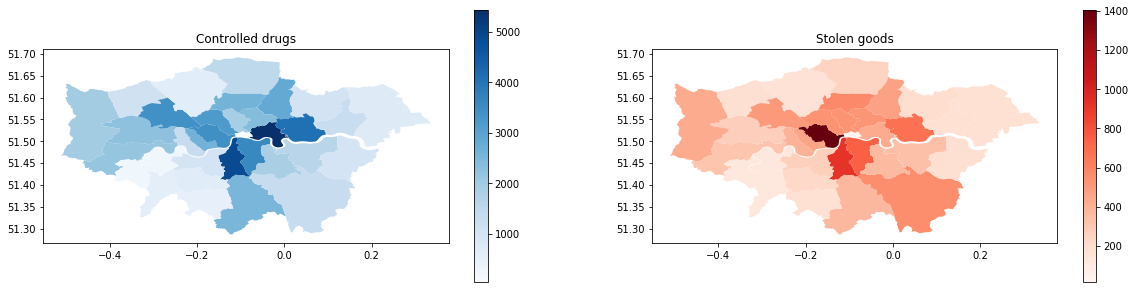

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))

p1=boroughs2.plot(column='Controlled drugs',ax=axs[0],cmap='Blues',legend=True);
axs[0].set_title('Controlled drugs', fontdict={'fontsize': '12', 'fontweight' : '5'});

p2=boroughs2.plot(column='Stolen goods',ax=axs[1], cmap='Reds',legend=True);
axs[1].set_title('Stolen goods', fontdict={'fontsize': '12', 'fontweight' : '5'});


<div class="alert alert-success">
 <b>EXERCISE</b> <br/> 
 Explore the data with GeoPandas. Again there are no right or wrong answers, the questions below give you some suggestions at what to look at. <br/> 
   <ul>
  <li>Improve the above maps. How many arrests are there in each borough? Use the above method but first select only the arrests using the column 'Outcome'. Can you plot this? </li>
  <li>Are there changes over time? Is there a difference between months? Use `street` and look at Westminster or another borough where the crime rate seems higher. </li>    
  </ul> 
</div>  

In [ ]:
# your data exploration (add as many cells as you need)


In [63]:
# %load https://raw.githubusercontent.com/IBMDeveloperUK/crime-data-workshop/master/answers/answer7.py
dfsjoin2 = gpd.sjoin(boroughs,stop_search[stop_search['Outcome'] == 'Arrest']) 
dfpivot2 = pd.pivot_table(dfsjoin2,index='code',columns='Object of search',aggfunc={'Object of search':'count'})
dfpivot2.columns = dfpivot2.columns.droplevel()
dfpivot2 = dfpivot2.reset_index()
boroughs3 = boroughs.merge(dfpivot2, how='left',on='code')
boroughs3.head()


,id,name,code,area_hectares,inner_statistical,geometry,Anything to threaten or harm anyone,Articles for use in criminal damage,Controlled drugs,Evidence of offences under the Act,Firearms,Fireworks,Offensive weapons,Stolen goods
0,1,Kingston upon Thames,E09000021,3726.117,0,(POLYGON ((-0.330679062942453 51.3290110106029...,1.0,2.0,76.0,28.0,2.0,NaN,27.0,42.0
1,2,Croydon,E09000008,8649.441,0,(POLYGON ((-0.064021239620113 51.3186376598749...,7.0,5.0,483.0,44.0,10.0,NaN,181.0,109.0
2,3,Bromley,E09000006,15013.487,0,"(POLYGON ((0.012130938509177 51.2995990596564,...",10.0,6.0,194.0,78.0,3.0,1.0,100.0,175.0
3,4,Hounslow,E09000018,5658.541,0,"(POLYGON ((-0.244562394525054 51.48870217634, ...",NaN,2.0,344.0,33.0,11.0,NaN,110.0,102.0
4,5,Ealing,E09000009,5554.428,0,(POLYGON ((-0.411832689731467 51.5340838625761...,1.0,NaN,311.0,29.0,6.0,NaN,95.0,70.0


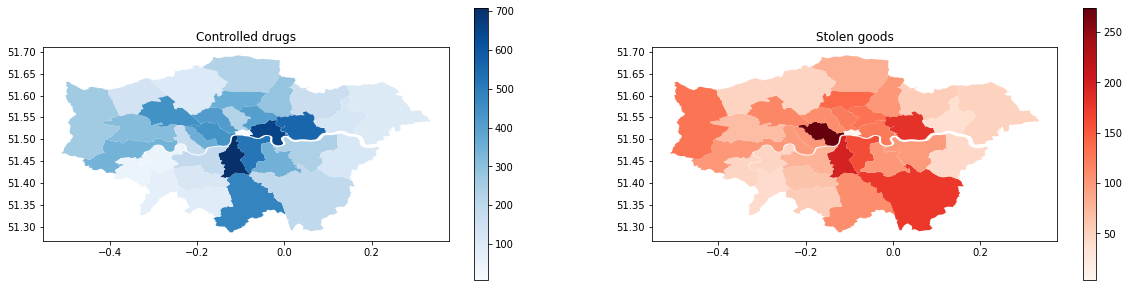

In [64]:
# %load https://raw.githubusercontent.com/IBMDeveloperUK/crime-data-workshop/master/answers/answer8.py
fig, axs = plt.subplots(1, 2, figsize=(20,5))

p1=boroughs3.plot(column='Controlled drugs',ax=axs[0],cmap='Blues',legend=True);
p2=boroughs3.plot(column='Stolen goods',ax=axs[1], cmap='Reds',legend=True);

axs[0].set_title('Controlled drugs', fontdict={'fontsize': '12', 'fontweight' : '5'});
axs[1].set_title('Stolen goods', fontdict={'fontsize': '12', 'fontweight' : '5'});


Hopefully you got an idea of the possibilities with geospatial data now. There is a lot more to explore with this data. Let me know if you find anything interesting! I am on Twitter as @MargrietGr. 

### Author
Margriet Groenendijk is a Data & AI Developer Advocate for IBM. She develops and presents talks and workshops about data science and AI. She is active in the local developer communities through attending, presenting and organising meetups. She has a background in climate science where she explored large observational datasets of carbon uptake by forests during her PhD, and global scale weather and climate models as a postdoctoral fellow. 

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.